
Mini Project
Title: "Dynamic Filtering and State-Contingent Signal Generation for USD/EUR Trading Strategy based on Interest Rate Differentials"

Description:
This project focuses on designing a trading strategy for the USD/EUR currency pair using interest rate differentials. The approach involves fitting a filter with a specified gain, computing standard deviations of filter errors, and generating state-contingent signals based on a boundary of inaction. The strategy aims to exploit market movements and adjust positions dynamically. The project further visualizes the filter and interest rate differentials, describes the trading strategy, presents the equity curve, computes annual rates of return, evaluates the Sharpe Ratio, and assesses the strategy's performance.Sensitivity analysis explores the impact of varying filter parameters on the strategy's behavior, seeking potential optimization for improved results.

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import datetime
import matplotlib.lines as mlines
from fredapi import Fred
import statsmodels.formula.api as smf
import datetime
import warnings
warnings.filterwarnings("ignore")

In [5]:
data = pd.read_csv('hw1_w24_data.csv', parse_dates =  True, index_col = 0)
data.head()

,I_US,I_EU,ir_diff,USDEUR
date,,,,
2004-01-01,1.10,2.1463,-1.046,0.79428
2004-02-01,1.06,2.0895,-1.030,0.80205
2004-03-01,1.05,2.0706,-1.021,0.80038
2004-04-01,1.05,2.0288,-0.979,0.81215
2004-05-01,1.08,2.0488,-0.969,0.83452


In [6]:
#Set the filter gain
k = 0.62

# Fit the filter and compute standard deviation of filter errors
data['Filter'] = data['ir_diff'].ewm(alpha=k, adjust=False).mean()
data['Filter Error'] = data['ir_diff'] - data['Filter']
data['Filter Error Std'] = data['Filter Error'].ewm(alpha=k, adjust=False).std(bias=False)



In [7]:
# Display the standard deviation
print("Standard Deviation of Filter Errors:")
print(data["Filter Error Std"])

Standard Deviation of Filter Errors:
date
2004-01-01         NaN
2004-02-01    0.004299
2004-03-01    0.002796
2004-04-01    0.008783
2004-05-01    0.005639
                ...   
2023-08-01    0.025732
2023-09-01    0.021986
2023-10-01    0.013553
2023-11-01    0.021268
2023-12-01    0.013352
Name: Filter Error Std, Length: 240, dtype: float64


In [8]:
# last value of the computed standard deviation
last_std_value = data['Filter Error Std'].iloc[-1]

print(f"The standard deviation of filter errors is: {last_std_value: .6f}")

The standard deviation of filter errors is:  0.013352


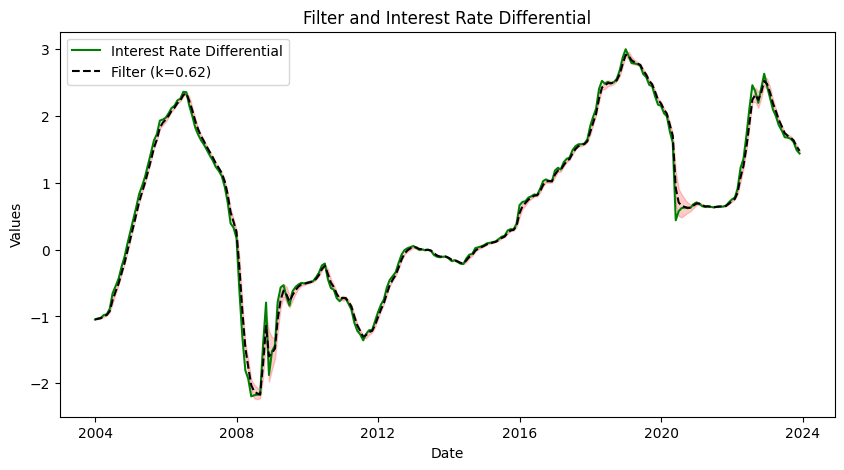

In [9]:
# Visualize the filter and interest rate differential on the same plot
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['ir_diff'], label='Interest Rate Differential', color='green')
plt.plot(data.index, data['Filter'], label=f'Filter (k={k})', color='black', linestyle='dashed')
plt.fill_between(data.index, data['Filter'] - data['Filter Error Std'], data['Filter'] + data['Filter Error Std'], color='red', alpha=0.2)
plt.title('Filter and Interest Rate Differential')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()



In [10]:
 #Generate signals when the interest rate crosses a boundary of inaction
z = 0.5
data["Upper"] = data["Filter"] + z*data["Filter Error Std"]
data["Lower"] = data["Filter"] - z*data["Filter Error Std"]

data["signal"] = np.where(data["Filter Error"].abs()>z*data["Filter Error Std"], 1, 0) * np.sign(data["Filter Error"])

# Display the resulting DataFrame with signals
data[['ir_diff', 'Filter', 'Filter Error', 'Filter Error Std', 'signal']]

,ir_diff,Filter,Filter Error,Filter Error Std,signal
date,,,,,
2004-01-01,-1.046,-1.046000,0.000000,NaN,0.0
2004-02-01,-1.030,-1.036080,0.006080,0.004299,1.0
2004-03-01,-1.021,-1.026730,0.005730,0.002796,1.0
2004-04-01,-0.979,-0.997138,0.018138,0.008783,1.0
2004-05-01,-0.969,-0.979692,0.010692,0.005639,1.0
...,...,...,...,...,...
2023-08-01,1.678,1.703429,-0.025429,0.025732,-1.0
2023-09-01,1.660,1.676503,-0.016503,0.021986,-1.0
2023-10-01,1.610,1.635271,-0.025271,0.013553,-1.0


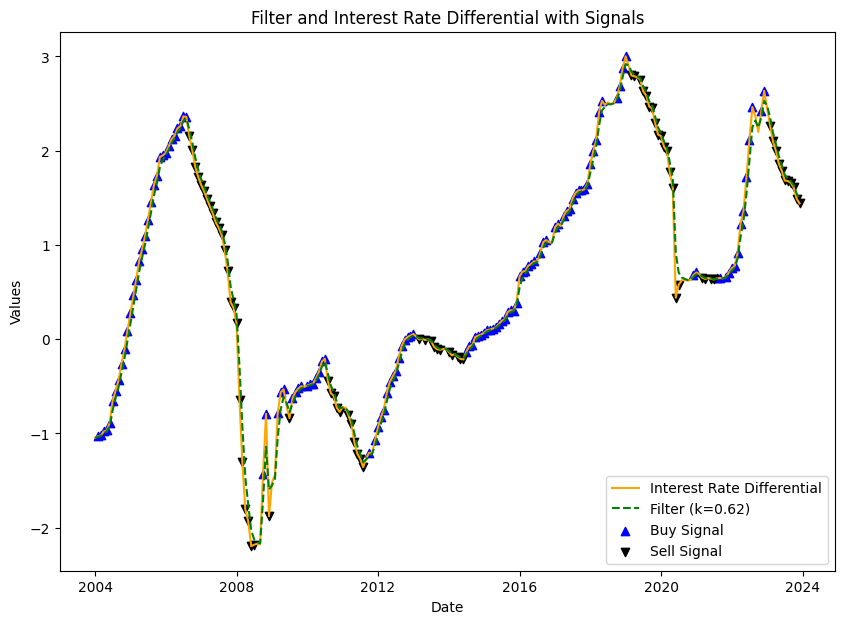

In [11]:
# Plotting the signals with IRD and Filter
plt.figure(figsize=(10, 7))
plt.plot(data.index, data['ir_diff'], label='Interest Rate Differential', color='orange')
plt.plot(data.index, data['Filter'], label=f'Filter (k={k})', color='green', linestyle='dashed')
plt.scatter(data[data['signal'] == 1].index, data.loc[data['signal'] == 1, 'ir_diff'], label='Buy Signal', color='blue', marker='^')
plt.scatter(data[data['signal'] == -1].index, data.loc[data['signal'] == -1, 'ir_diff'], label='Sell Signal', color='black', marker='v')


plt.title("Filter and Interest Rate Differential with Signals")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()




 Description of Strategy:
 In constructing the filter for this trading strategy, I opted for a I opted for a filter gain (alpha) of k =0.62, leveraging an exponentially weighted moving average (EWMA). The primary goal wasto create a filter that could capture trends in the interest rate differential while smoothing out noise in the time series. This filtered output was intended to offer a more refined estimate of the underlying trend in the interest rate differential.
The calculation of the filter error involved taking the difference between the observed IRD and the corresponding value of the filter. This served as a measure of how much the actual data deviated from the smoothed trend. To gauge the variability or volatility of these filter errors over time, I computed their standard deviation using the same EWMA with the filter gain (alpha) set at 0.62.
Signal generation in this strategy hinged on the identification of boundary crossings around the filter. These boundaries, defined as the filter value plus or minus z times the standard deviation of the filter errors, acted as thresholds for triggering signals. If the absolute value of the filter error surpassed z times the standard deviation, a signal was initiated. The sign of the signal was then determined by the sign of the filter error. These signals were designed to be state contingent, taking into account the current state of the filter error inrelation to its historical variability.
Interpreting the signals is straightforward. A triggered signal indicates a substantial deviation from the filtered trend, presenting a potential trading opportunity. A positive signal(1.0) implied a bullish stance, suggesting that the interest rate differential had significantly exceeded the upper boundary of inaction. Conversely, a negative signal (-1.0) signaled a bearish position, indicating a substantial drop in the interest rate differential below the lowerboundary of inaction.
When it comes to implementing the s.trategy, traders could leverage these signals to inform their trading decisions. This might involve entering either long or short positions in market, depending on the direction of the signals. My strategy integrates filtering techniques with signal generation, relying on deviations from historical volatility to guide informed decisions made by investor.

In [12]:

data['returns'] = np.log(data['USDEUR']).diff()
# Before multipling the signals are shifted by one period
data['strat returns'] = data['signal'].shift()*data['returns']

# Use summation to get cumulative log returns
data['log strategy returns'] = data['strat returns'].cumsum()

# convert into simple returns
data['simple strategy returns'] = np.exp(data['log strategy returns'])-1

data.tail()

,I_US,I_EU,ir_diff,USDEUR,Filter,Filter Error,Filter Error Std,Upper,Lower,signal,returns,strat returns,log strategy returns,simple strategy returns
date,,,,,,,,,,,,,,
2023-08-01,5.35,3.6718,1.678,0.90709,1.703429,-0.025429,0.025732,1.716295,1.690563,-1.0,-0.014273,0.014273,0.604427,0.830203
2023-09-01,5.44,3.7803,1.660,0.91470,1.676503,-0.016503,0.021986,1.687496,1.665510,-1.0,0.008354,-0.008354,0.596073,0.814977
2023-10-01,5.49,3.8800,1.610,0.94675,1.635271,-0.025271,0.013553,1.642048,1.628495,-1.0,0.034439,-0.034439,0.561634,0.753535
2023-11-01,5.46,3.9700,1.490,0.94206,1.545203,-0.055203,0.021268,1.555837,1.534569,-1.0,-0.004966,0.004966,0.566600,0.762265
2023-12-01,5.41,3.9700,1.440,0.91127,1.479977,-0.039977,0.013352,1.486653,1.473301,-1.0,-0.033230,0.033230,0.599830,0.821808


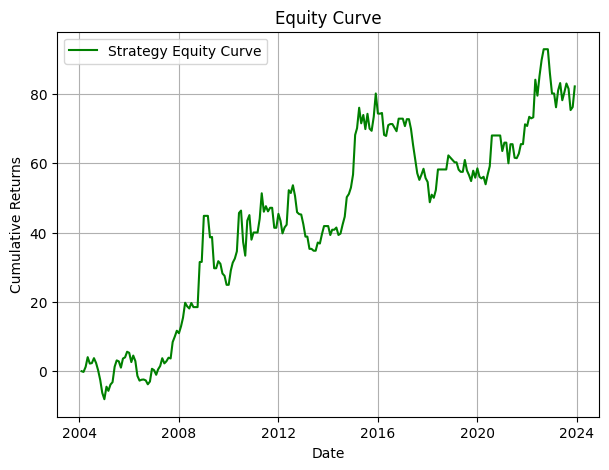

In [13]:
plt.figure(figsize = (7, 5))
plt.plot(data['simple strategy returns'][data.index.year <2024]*100,label='Strategy Equity Curve', color='green')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()

CCROR stands for Continuously Compounded Rate of Return and Annual Return:



In [20]:
data["total_returns"] = (data["simple strategy returns"] + 1)
CCROR = np.log(data["total_returns"].iloc[-1])/(len(data)/12)
CCROR*100

2.9991478541823806

In [21]:
AR = (np.power(data["total_returns"] .iloc[-1],(1/(len(data)/12)))-1)
AR*100

3.0445753015716503

In [32]:
# Aggregate strategy returns at the monthly level
monthly = np.exp(data['simple strategy returns'].resample('M').sum()) - 1

monthly

date
2004-01-31    0.000000
2004-02-29    0.000000
2004-03-31   -0.002080
2004-04-30    0.012672
2004-05-31    0.041314
                ...   
2023-08-31    1.293785
2023-09-30    1.259123
2023-10-31    1.124497
2023-11-30    1.143125
2023-12-31    1.274609
Freq: M, Name: simple strategy returns, Length: 240, dtype: float64

Annual risk free rate: assumed to be fixed at 2%

In [33]:

rf= 0.02
excess = monthly - rf
sharpe= excess.mean()/excess.std()*np.sqrt(12)
sharpe

4.961068403459206

In [14]:
# Aggregate strategy returns at the Yearly level
Yearly = np.exp(data['simple strategy returns'].resample('Y').sum()) - 1

Yearly

date
2004-12-31        0.075517
2005-12-31       -0.036184
2006-12-31       -0.022532
2007-12-31        0.612616
2008-12-31        9.396490
2009-12-31       62.196995
2010-12-31       81.649165
2011-12-31      203.824944
2012-12-31      260.353887
2013-12-31       95.983864
2014-12-31      188.698953
2015-12-31     5094.189973
2016-12-31     5330.191408
2017-12-31     2178.462142
2018-12-31      823.784708
2019-12-31     1081.306827
2020-12-31     1576.291094
2021-12-31     2311.009545
2022-12-31    20665.096485
2023-12-31    14401.565349
Freq: A-DEC, Name: simple strategy returns, dtype: float64

In [15]:
rf= 0.02
excess = Yearly - rf
sharpe= excess.mean()/excess.std()*np.sqrt(12)
print('The Sharpe ratio is', sharpe.round(3),'%')

The Sharpe ratio is 1.741 %


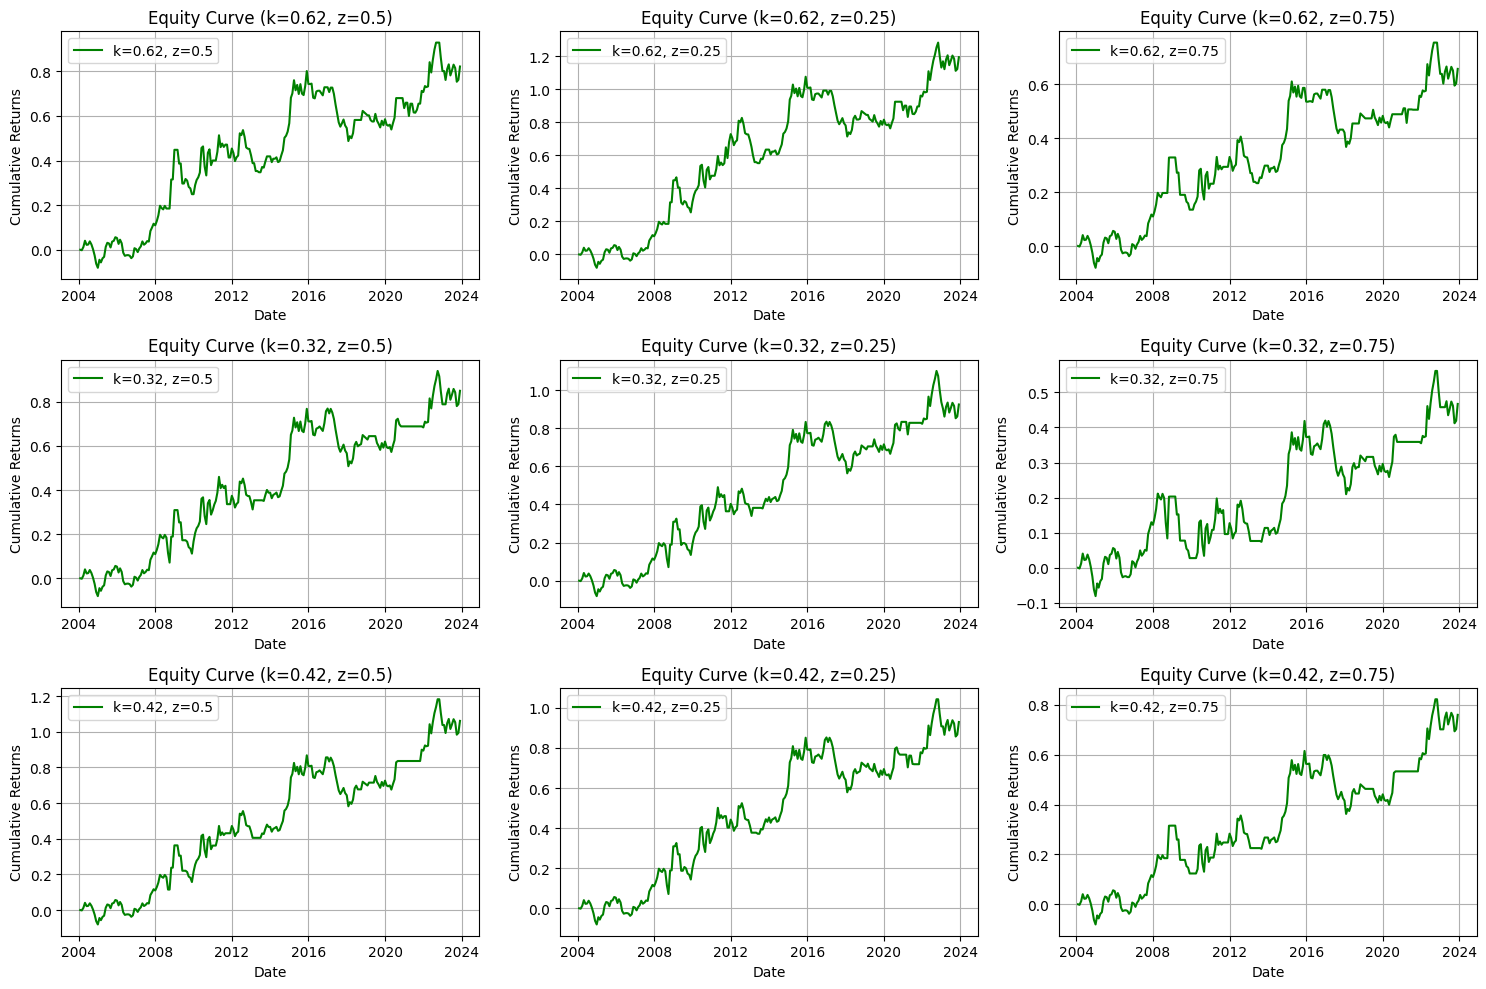

Sharpe Ratio (k=0.62, z=0.5): 1.7412506975722526
Sharpe Ratio (k=0.62, z=0.25): 1.333429485743395
Sharpe Ratio (k=0.62, z=0.75): 1.908728499735542
Sharpe Ratio (k=0.32, z=0.5): 1.811754038790672
Sharpe Ratio (k=0.32, z=0.25): 1.4994431670901984
Sharpe Ratio (k=0.32, z=0.75): 2.115988670153232
Sharpe Ratio (k=0.42, z=0.5): 1.306745598571725
Sharpe Ratio (k=0.42, z=0.25): 1.67462760643206
Sharpe Ratio (k=0.42, z=0.75): 1.4547848561100503


In [16]:
# Initial parameters
k_values = [0.62, 0.32, 0.42]
z_values = [0.5, 0.25, 0.75]
rf = 0.02  # Constant annual risk-free rate

plt.figure(figsize=(15, 10))

# Calculate Sharpe ratios for each combination
sharpe_ratios = []

for i in range(3):
    k = k_values[i]
    
    for j in range(3):
        z = z_values[j]
        
        # Set the filter gain
        data['Filter'] = data['ir_diff'].ewm(alpha=k, adjust=False).mean()
        data['Filter Error'] = data['ir_diff'] - data['Filter']
        data['Filter Error Std'] = data['Filter Error'].ewm(alpha=k, adjust=False).std(bias=False)
        
        # Generate signals based on filter and z
        data["signal"] = np.where(data["Filter Error"].abs() > z * data["Filter Error Std"], 1, 0) * np.sign(data["Filter Error"])
        
        # Calculate strategy returns
        data['Returns'] = np.log(data['USDEUR']).diff()
        data['Strategy Returns'] = data['signal'].shift(1) * data['returns']
        data['log strategy returns'] = data['Strategy Returns'].cumsum()
        data['simple strategy returns'] = np.exp(data['log strategy returns']) - 1

        # Calculate Sharpe ratio
        monthly = np.exp(data['simple strategy returns'].resample('Y').sum()) - 1
        rf = 0.02
        excess = monthly - rf
        sharpe = excess.mean() / excess.std() * np.sqrt(12)
        sharpe_ratios.append((k, z, sharpe))

        # Plot equity curve
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.plot(data['simple strategy returns'], label=f'k={k}, z={z}', color='green')
        plt.title(f'Equity Curve (k={k}, z={z})')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.grid()

plt.tight_layout()
plt.show()

# Print Sharpe ratios for each combination
for k, z, sharpe in sharpe_ratios:
    print(f'Sharpe Ratio (k={k}, z={z}): {sharpe}')


Lower values of k make the filter more responsive to recent changes, while higher values make it smoother. Different values of z impact the sensitivity of signal generation to filter errors.

A higher Sharpe ratio generally indicates a better risk-adjusted performance. Sharpe Ratio (k=0.62, z=0.75): 1.909%. Therefore, the strategy with parameters k=0.62 and z=0.75 is considered better based on the Sharpe ratio among the provided combinations.

Using hypothetical  interest rate and shock impact ( to visualize the graph of IRD and Exchange rate in 2 cases

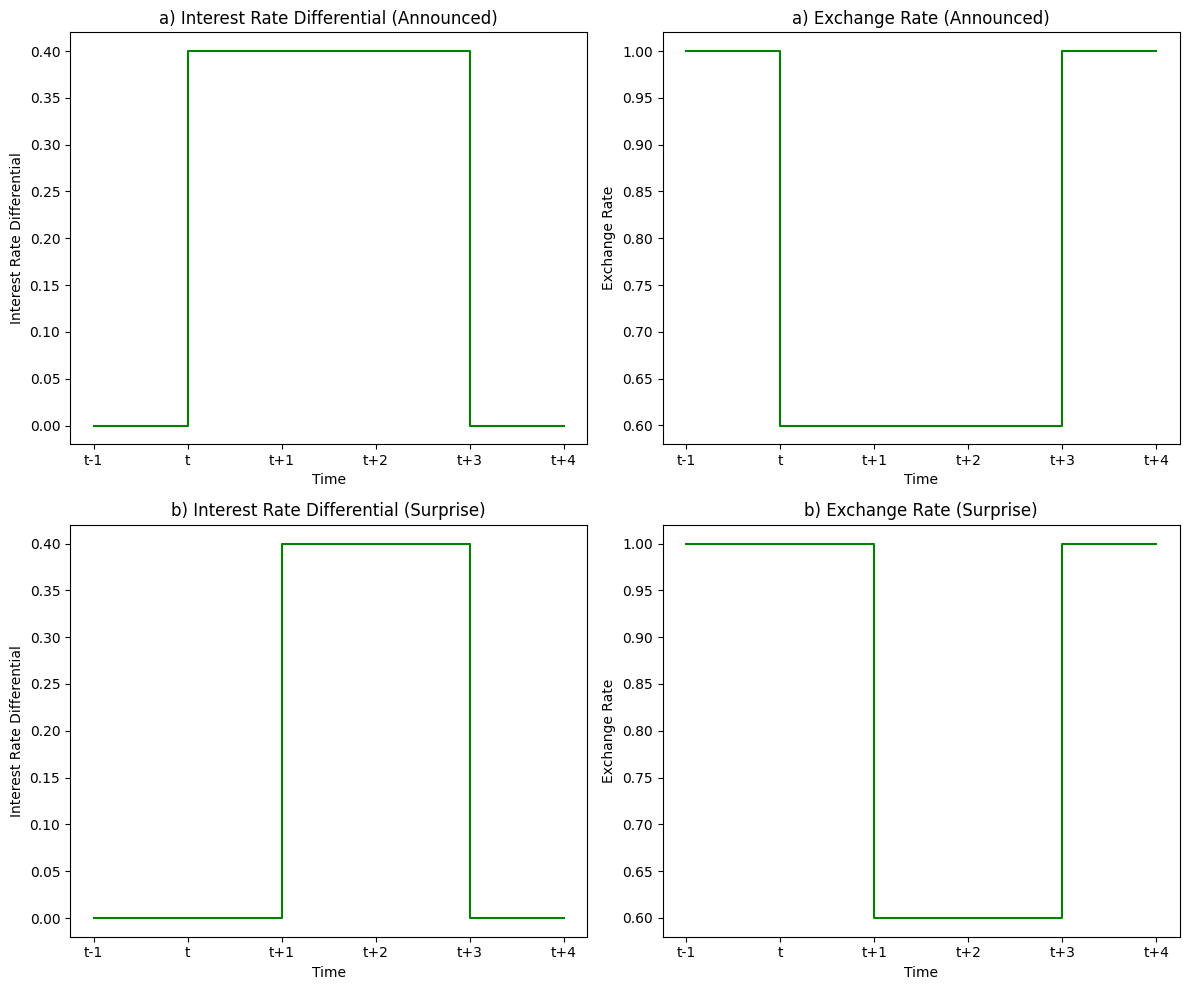

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
T= 6
x = [1,2,3,4,5,6]
shock_size = 0.4

# Scenario (a): The t+1 shock is announced at time t
IRD_announced = np.zeros(T)
IRD_announced[1:4] = shock_size

ER_announced = np.ones(T)
ER_announced[1:4] -= shock_size

# Scenario (b): The t+1 shock is not announced at time t but it is a surprise
IRD_surprise = np.zeros(T)
IRD_surprise[2:4] = shock_size

ER_surprise = np.ones(T)
ER_surprise[2:4] -= shock_size

# Plotting
plt.figure(figsize=(12, 10))

# Graph 1: Interest rate differential (Announced)
plt.subplot(2, 2, 1)
plt.step(x, IRD_announced, where='post', color = 'g')
plt.xticks(x, ['t-1', 't', 't+1', 't+2', 't+3','t+4'])
plt.title('a) Interest Rate Differential (Announced)')
plt.xlabel('Time')
plt.ylabel('Interest Rate Differential')


# Graph 2: Exchange rate (Announced)
plt.subplot(2, 2, 2)
plt.step(x, ER_announced, where='post', color = 'g')
plt.xticks(x, ['t-1', 't', 't+1', 't+2', 't+3','t+4'])
plt.title('a) Exchange Rate (Announced)')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')


# Graph 3: Interest rate differential (Surprise)
plt.subplot(2, 2, 3)
plt.step(x, IRD_surprise, where='post', color = 'g')
plt.xticks(x, ['t-1', 't', 't+1', 't+2', 't+3','t+4'])
plt.title('b) Interest Rate Differential (Surprise)')
plt.xlabel('Time')
plt.ylabel('Interest Rate Differential')


# Graph 4: Exchange rate (Surprise)
plt.subplot(2, 2, 4)
plt.step(x, ER_surprise, where='post',color = 'g')
plt.xticks(x, ['t-1', 't', 't+1', 't+2', 't+3','t+4'])
plt.title('b) Exchange Rate (Surprise)')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')


plt.tight_layout()
plt.show()


In [ ]:
pip install nbconvert PyPDF2

     ---------------------------------------- 0.0/232.6 kB ? eta -:--:--
     --------------------------------- ---- 204.8/232.6 kB 6.1 MB/s eta 0:00:01
     -------------------------------------- 232.6/232.6 kB 4.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
